In [1]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook
output_notebook()

%matplotlib inline

Loading BokehJS ...

In [2]:
datafile = 'F:/Data Science/JigSaw/Fast revision/NLP/Topic Modelling/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


In [4]:
raw_data = raw_data.head(1000)

In [10]:
raw_data["headline_text"]

0      aba decides against community broadcasting lic...
1         act fire witnesses must be aware of defamation
2         a g calls for infrastructure protection summit
3               air nz staff in aust strike for pay rise
4          air nz strike to affect australian travellers
5                      ambitious olsson wins triple jump
6             antic delighted with record breaking barca
7      aussie qualifier stosur wastes four memphis match
8           aust addresses un security council over iraq
9             australia is locked into war timetable opp
10     australia to contribute 10 million in aid to iraq
11     barca take record as robson celebrates birthda...
12                            bathhouse plans move ahead
13         big hopes for launceston cycling championship
14                big plan to boost paroo water supplies
15                blizzard buries united states in bills
16        brigadier dismisses reports troops harassed in
17        british combat troops

In [6]:
#First we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data. 
#Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

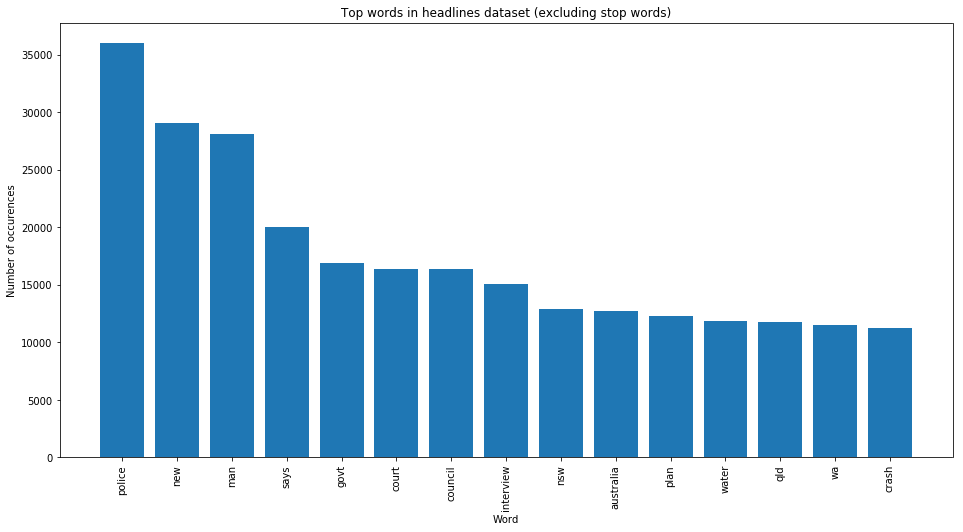

In [12]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values);
ax.set_xticks(range(len(words)));
ax.set_xticklabels(words, rotation='vertical');
ax.set_title('Top words in headlines dataset (excluding stop words)');
ax.set_xlabel('Word');
ax.set_ylabel('Number of occurences');
plt.show()

In [17]:
#Next we generate a histogram of headline word lengths, and use part-of-speech tagging to understand the types 
#of words used across the corpus. This requires first converting all headline strings to TextBlobs and calling the pos_tags 
#method on each, yielding a list of tagged words for each headline. A complete list of such word tags is available
tagged_headlines = [TextBlob(reindexed_data[i]).pos_tags for i in range(raw_data["headline_text"].shape[0])]

In [15]:
import nltk
nltk.download() #Download averaged_perceptron_tagger and run below code again

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [18]:
tagged_headlines

[[('aba', 'JJ'),
  ('decides', 'NNS'),
  ('against', 'IN'),
  ('community', 'NN'),
  ('broadcasting', 'NN'),
  ('licence', 'NN')],
 [('act', 'NN'),
  ('fire', 'NN'),
  ('witnesses', 'NNS'),
  ('must', 'MD'),
  ('be', 'VB'),
  ('aware', 'JJ'),
  ('of', 'IN'),
  ('defamation', 'NN')],
 [('a', 'DT'),
  ('g', 'NN'),
  ('calls', 'VBZ'),
  ('for', 'IN'),
  ('infrastructure', 'NN'),
  ('protection', 'NN'),
  ('summit', 'NN')],
 [('air', 'NN'),
  ('nz', 'JJ'),
  ('staff', 'NN'),
  ('in', 'IN'),
  ('aust', 'NN'),
  ('strike', 'NN'),
  ('for', 'IN'),
  ('pay', 'NN'),
  ('rise', 'NN')],
 [('air', 'NN'),
  ('nz', 'NNS'),
  ('strike', 'NN'),
  ('to', 'TO'),
  ('affect', 'VB'),
  ('australian', 'JJ'),
  ('travellers', 'NNS')],
 [('ambitious', 'JJ'),
  ('olsson', 'NN'),
  ('wins', 'VBZ'),
  ('triple', 'JJ'),
  ('jump', 'NN')],
 [('antic', 'JJ'),
  ('delighted', 'VBD'),
  ('with', 'IN'),
  ('record', 'NN'),
  ('breaking', 'NN'),
  ('barca', 'NN')],
 [('aussie', 'RB'),
  ('qualifier', 'JJR'),
  ('stosu

In [19]:
tagged_headlines_df = pd.DataFrame({'tags':tagged_headlines})

word_counts = [] 
pos_counts = {}

for headline in tagged_headlines_df[u'tags']:
    word_counts.append(len(headline))
    for tag in headline:
        if tag[1] in pos_counts:
            pos_counts[tag[1]] += 1
        else:
            pos_counts[tag[1]] = 1
            
print('Total number of words: ', np.sum(word_counts))
print('Mean number of words per headline: ', np.mean(word_counts))

Total number of words:  6499
Mean number of words per headline:  6.499


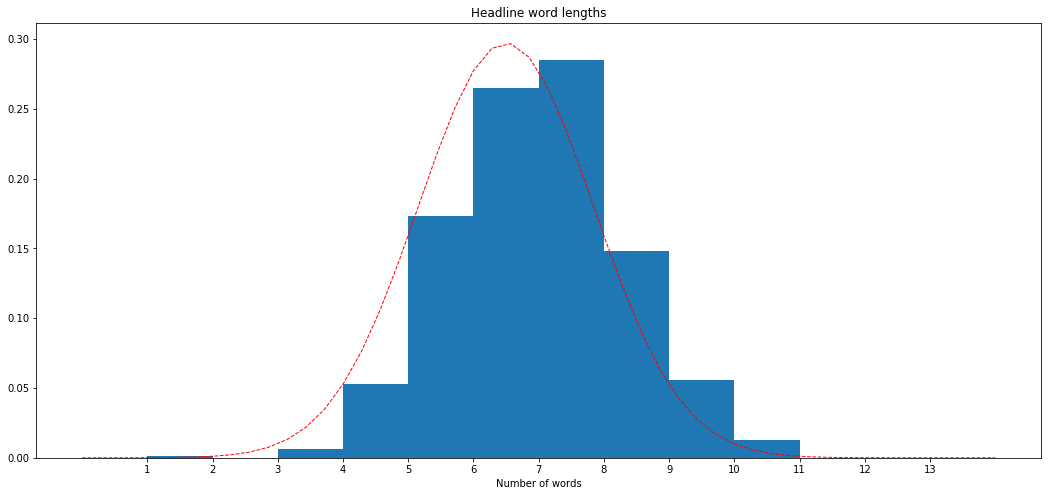

In [20]:
y = stats.norm.pdf(np.linspace(0,14,50), np.mean(word_counts), np.std(word_counts))

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(word_counts, bins=range(1,14), density=True);
ax.plot(np.linspace(0,14,50), y, 'r--', linewidth=1);
ax.set_title('Headline word lengths');
ax.set_xticks(range(1,14));
ax.set_xlabel('Number of words');
plt.show()

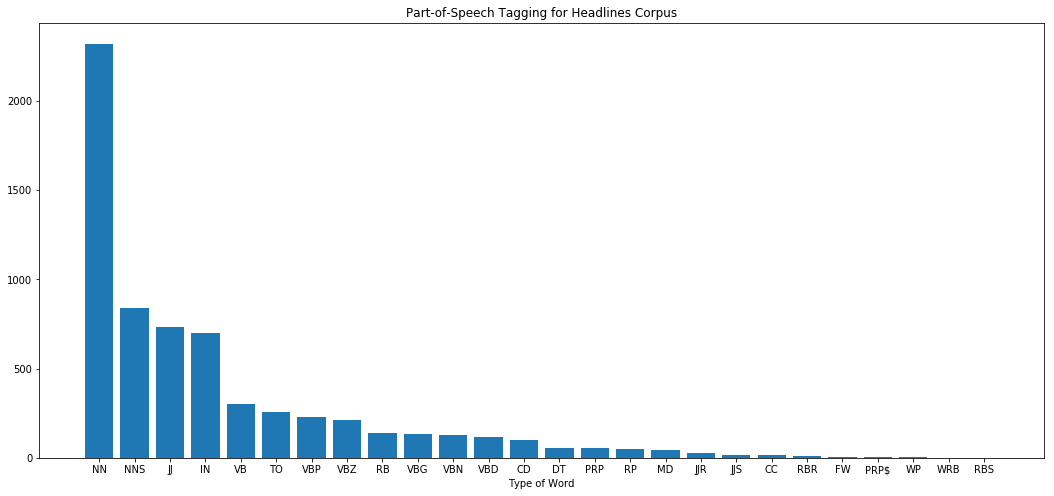

In [21]:
pos_sorted_types = sorted(pos_counts, key=pos_counts.__getitem__, reverse=True)
pos_sorted_counts = sorted(pos_counts.values(), reverse=True)

fig, ax = plt.subplots(figsize=(18,8))
ax.bar(range(len(pos_counts)), pos_sorted_counts);
ax.set_xticks(range(len(pos_counts)));
ax.set_xticklabels(pos_sorted_types);
ax.set_title('Part-of-Speech Tagging for Headlines Corpus');
ax.set_xlabel('Type of Word');

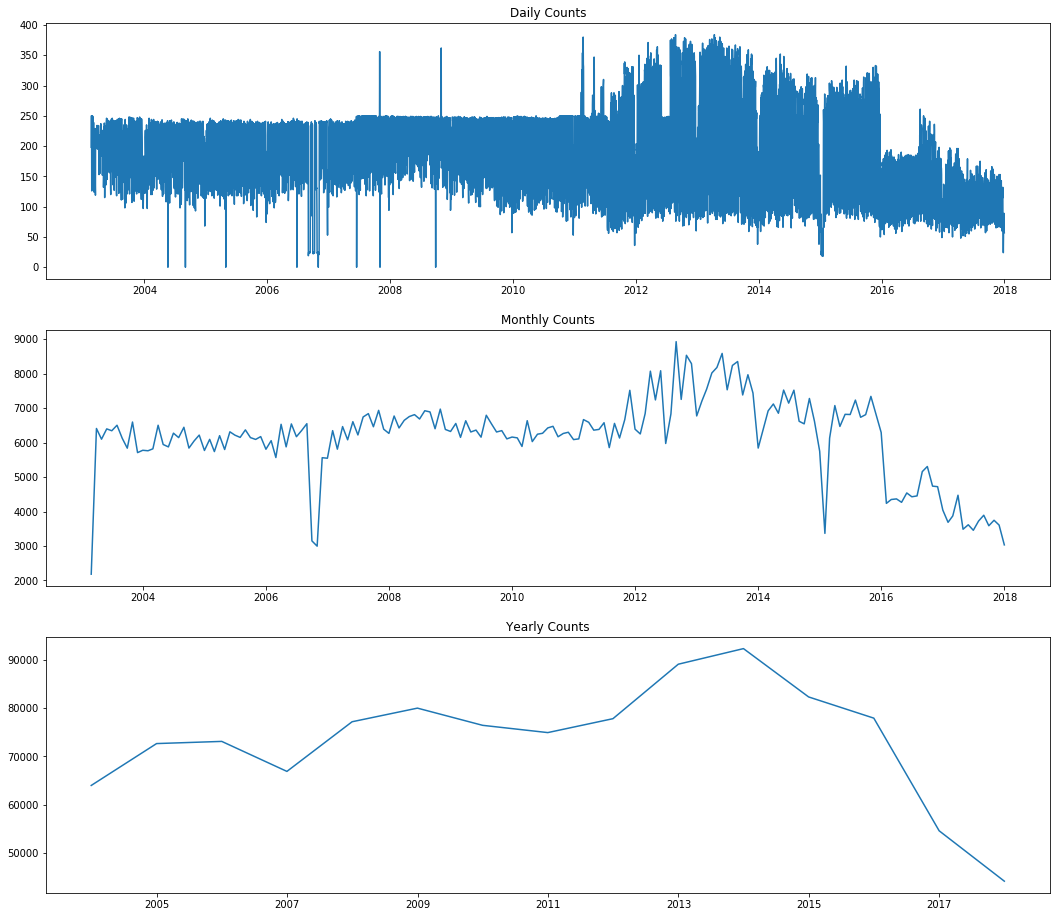

In [22]:
#By plotting the number of headlines published per day, per month and per year, we can also get a sense of the sample density.
monthly_counts = reindexed_data.resample('M').count()
yearly_counts = reindexed_data.resample('A').count()
daily_counts = reindexed_data.resample('D').count()

fig, ax = plt.subplots(3, figsize=(18,16))
ax[0].plot(daily_counts);
ax[0].set_title('Daily Counts');
ax[1].plot(monthly_counts);
ax[1].set_title('Monthly Counts');
ax[2].plot(yearly_counts);
ax[2].set_title('Yearly Counts');
plt.show()

In [27]:
#Topic modelling:
#use CountVectorizer to create a document term matrix
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=40000)

print('Headline before vectorization: {}'.format(raw_data["headline_text"][123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(raw_data["headline_text"])

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

C:\Users\sunny\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Headline before vectorization: pair to face court  over  ayr murder
Headline after vectorization: 
  (0, 215)	1
  (0, 888)	1
  (0, 1685)	1
  (0, 1562)	1
  (0, 607)	1


In [28]:
n_topics = 8

In [29]:
#LSA
lsa_model = TruncatedSVD(n_components=n_topics)
lsa_topic_matrix = lsa_model.fit_transform(small_document_term_matrix)

In [31]:
#Taking the  argmax  of each headline in this topic matrix will give the predicted topics of each headline in the sample.
#We can then sort these into counts of each topic
# Define helper functions
def get_keys(topic_matrix):
    '''
    returns an integer list of predicted topic 
    categories for a given topic matrix
    '''
    keys = topic_matrix.argmax(axis=1).tolist()
    return keys

def keys_to_counts(keys):
    '''
    returns a tuple of topic categories and their 
    accompanying magnitudes for a given list of keys
    '''
    count_pairs = Counter(keys).items()
    categories = [pair[0] for pair in count_pairs]
    counts = [pair[1] for pair in count_pairs]
    return (categories, counts)

In [32]:
lsa_keys = get_keys(lsa_topic_matrix)
lsa_categories, lsa_counts = keys_to_counts(lsa_keys)

In [33]:
#However, these topic categories are in and of themselves a little meaningless. 
#In order to better characterise them, it will be helpful to find the most frequent words in each.
# Define helper functions
def get_top_n_words(n, keys, document_term_matrix, count_vectorizer):
    '''
    returns a list of n_topic strings, where each string contains the n most common 
    words in a predicted category, in order
    '''
    top_word_indices = []
    for topic in range(n_topics):
        temp_vector_sum = 0
        for i in range(len(keys)):
            if keys[i] == topic:
                temp_vector_sum += document_term_matrix[i]
        temp_vector_sum = temp_vector_sum.toarray()
        top_n_word_indices = np.flip(np.argsort(temp_vector_sum)[0][-n:],0)
        top_word_indices.append(top_n_word_indices)   
    top_words = []
    for topic in top_word_indices:
        topic_words = []
        for index in topic:
            temp_word_vector = np.zeros((1,document_term_matrix.shape[1]))
            temp_word_vector[:,index] = 1
            the_word = count_vectorizer.inverse_transform(temp_word_vector)[0][0]
            topic_words.append(the_word.encode('ascii').decode('utf-8'))
        top_words.append(" ".join(topic_words))         
    return top_words

In [34]:
top_n_words_lsa = get_top_n_words(10, lsa_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lsa)):
    print("Topic {}: ".format(i+1), top_n_words_lsa[i])

Topic 1:  man charged murder stabbing jailed leads court hospital bid stuttle
Topic 2:  rain water drought says plan meeting group patterson act expected
Topic 3:  iraq win turkey british world funds stay qantas million downer
Topic 4:  police death crash probe korean injured missing search help continue
Topic 5:  court new face high claim set wins trial takes charges
Topic 6:  nsw govt record sa plans nt makes calls coast work
Topic 7:  council indigenous day tas education decision mp considers concerns health
Topic 8:  war anti protesters pm criticism howard rout heads strikers protest


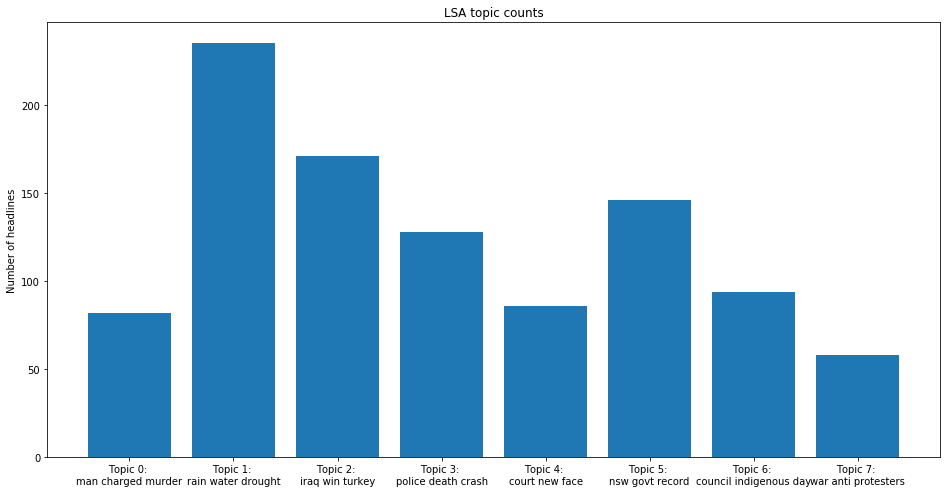

In [35]:
top_3_words = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lsa_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lsa_categories, lsa_counts);
ax.set_xticks(lsa_categories);
ax.set_xticklabels(labels);
ax.set_ylabel('Number of headlines');
ax.set_title('LSA topic counts');
plt.show()

In [36]:
#However, this does not provide a great point of comparison with other clustering algorithms.
#In order to properly contrast LSA with LDA we instead use a dimensionality-reduction technique called  t -SNE,
#which will also serve to better illuminate the success of the clustering process.
tsne_lsa_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lsa_vectors = tsne_lsa_model.fit_transform(lsa_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.764s...
[t-SNE] Computed neighbors for 1000 samples in 0.620s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.007681
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.645027
[t-SNE] Error after 2000 iterations: 0.563767


In [37]:
#Now that we have reduced these n_topics-dimensional vectors to two-dimensional representations, 
#we can then plot the clusters using Bokeh. Before doing so however, it will be useful to derive the centroid location
#of each topic, so as to better contextualise our visualisation.
# Define helper functions
def get_mean_topic_vectors(keys, two_dim_vectors):
    '''
    returns a list of centroid vectors from each predicted topic category
    '''
    mean_topic_vectors = []
    for t in range(n_topics):
        articles_in_that_topic = []
        for i in range(len(keys)):
            if keys[i] == t:
                articles_in_that_topic.append(two_dim_vectors[i])    
        
        articles_in_that_topic = np.vstack(articles_in_that_topic)
        mean_article_in_that_topic = np.mean(articles_in_that_topic, axis=0)
        mean_topic_vectors.append(mean_article_in_that_topic)
    return mean_topic_vectors

In [38]:
colormap = np.array([
    "#1f77b4", "#aec7e8", "#ff7f0e", "#ffbb78", "#2ca02c",
    "#98df8a", "#d62728", "#ff9896", "#9467bd", "#c5b0d5",
    "#8c564b", "#c49c94", "#e377c2", "#f7b6d2", "#7f7f7f",
    "#c7c7c7", "#bcbd22", "#dbdb8d", "#17becf", "#9edae5" ])
colormap = colormap[:n_topics]

In [39]:
#All that remains is to plot the clustered headlines. Also included are the top three words in each 
#cluster, which are placed at the centroid for that topic.
top_3_words_lsa = get_top_n_words(3, lsa_keys, small_document_term_matrix, small_count_vectorizer)
lsa_mean_topic_vectors = get_mean_topic_vectors(lsa_keys, tsne_lsa_vectors)

plot = figure(title="t-SNE Clustering of {} LSA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lsa_vectors[:,0], y=tsne_lsa_vectors[:,1], color=colormap[lsa_keys])

for t in range(n_topics):
    label = Label(x=lsa_mean_topic_vectors[t][0], y=lsa_mean_topic_vectors[t][1], 
                  text=top_3_words_lsa[t], text_color=colormap[t])
    plot.add_layout(label)
    
show(plot)

In [40]:
#Evidently, this is a bit a of a failed result. We have failed to reach any great degree of separation across the topic
#categories, and it is difficult to tell whether this can be attributed to the LSA decomposition or instead
#the  t -SNE dimensionality reduction process. Let's move forward and try another clustering technique.


In [41]:
#Latent Dirichilet Allocation
lda_model = LatentDirichletAllocation(n_components=n_topics, learning_method='online', 
                                          random_state=0, verbose=0)
lda_topic_matrix = lda_model.fit_transform(small_document_term_matrix)

In [42]:
#Once again, we take the  argmax  of each entry in the topic matrix to obtain the predicted topic category for each headline.
#These topic categories can then be characterised by their most frequent words.
lda_keys = get_keys(lda_topic_matrix)
lda_categories, lda_counts = keys_to_counts(lda_keys)

In [43]:
top_n_words_lda = get_top_n_words(10, lda_keys, small_document_term_matrix, small_count_vectorizer)

for i in range(len(top_n_words_lda)):
    print("Topic {}: ".format(i+1), top_n_words_lda[i])

Topic 1:  iraq police drought turkey nsw says offer rain council govt
Topic 2:  new world continues takes masters nsw pm million search flooding
Topic 3:  federal stay day pm arsenal act final seat seaman dubai
Topic 4:  wa coast strike club gold korean peace group ban review
Topic 5:  crash anti injured urged nightclub funds brawl war claim education
Topic 6:  govt claims new race cup health war prices rain rejects
Topic 7:  man court murder face water charged police plan death iraq
Topic 8:  council win record security super planned firefighters rain open warne


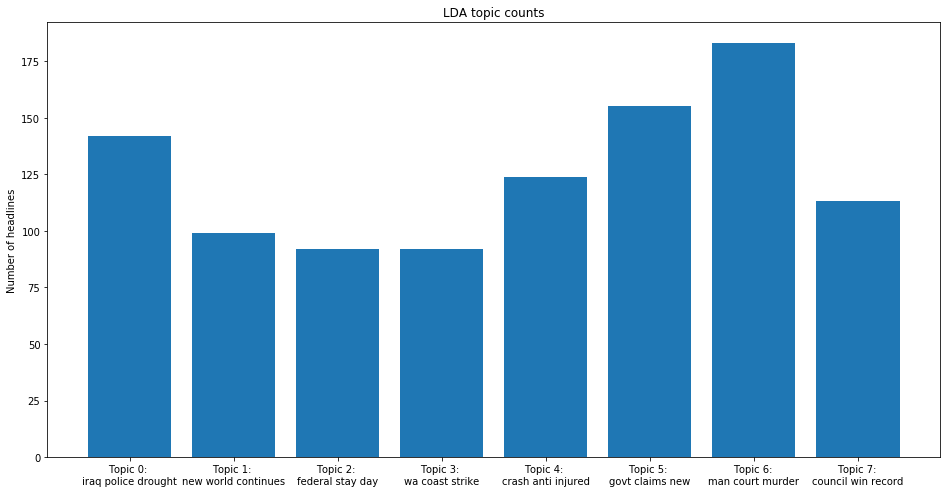

In [44]:
#The relative topic compositions of the sample are then illustated with a barchart.
top_3_words = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
labels = ['Topic {}: \n'.format(i) + top_3_words[i] for i in lda_categories]

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(lda_categories, lda_counts);
ax.set_xticks(lda_categories);
ax.set_xticklabels(labels);
ax.set_title('LDA topic counts');
ax.set_ylabel('Number of headlines');

In [45]:
#However, in order to properly compare LDA with LSA,
#we again take this topic matrix and project it into two dimensions with  t -SNE.
tsne_lda_model = TSNE(n_components=2, perplexity=50, learning_rate=100, 
                        n_iter=2000, verbose=1, random_state=0, angle=0.75)
tsne_lda_vectors = tsne_lda_model.fit_transform(lda_topic_matrix)

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.008s...
[t-SNE] Computed neighbors for 1000 samples in 0.264s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 0.025963
[t-SNE] KL divergence after 250 iterations with early exaggeration: 43.090290
[t-SNE] Error after 1650 iterations: 0.163761


In [46]:
top_3_words_lda = get_top_n_words(3, lda_keys, small_document_term_matrix, small_count_vectorizer)
lda_mean_topic_vectors = get_mean_topic_vectors(lda_keys, tsne_lda_vectors)

plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), plot_width=700, plot_height=700)
plot.scatter(x=tsne_lda_vectors[:,0], y=tsne_lda_vectors[:,1], color=colormap[lda_keys])

for t in range(n_topics):
    label = Label(x=lda_mean_topic_vectors[t][0], y=lda_mean_topic_vectors[t][1], 
                  text=top_3_words_lda[t], text_color=colormap[t])
    plot.add_layout(label)

show(plot)

In [47]:
#This is a much better result! Controlling for  t -SNE, it would seem that LDA has had much more succcess than LSA in separating
#out the topic categories. For this reason, LDA appears the more appropriate
#algorithm when we scale up the clustering process in the next section.